In [134]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from tqdm import tqdm
from numpy import array
from core.utils import *
import atlas_mpl_style as ampl
import random
import mplhep as hep
hep.style.use("ATLAS")
import random

pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new_hrzhao'#note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'

In [2]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600, 800, 1000, 1200, 1500]
bin_centers = 0.5 * (np.array(label_ptrange[:-1]) + np.array(label_ptrange[1:]))
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT"
}
HistBins={
   "jet_nTracks": np.linspace(0, 60, 61),
   'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}

Map_gen={
"nominal": "Pythia 8",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia 8",
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [150]:
def Plot_ROC(Extraction_Results, output_path,vars):
    swaped_Extraction_Results = {}
    label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
    #label_var = ['jet_nTracks']#, 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
    
    var = vars[0]

    for syst in Extraction_Results.keys():
        swaped_Extraction_Results[syst]={}
        label_keys = [*Extraction_Results[syst]['jet_nTracks'][500]] 
        for l_ptrange in label_ptrange[:-1]:
            swaped_Extraction_Results[syst][l_ptrange] = {}
            for l_key in label_keys:
                swaped_Extraction_Results[syst][l_ptrange][l_key] = {}
                for l_var in vars:
                    swaped_Extraction_Results[syst][l_ptrange][l_key][l_var] = Extraction_Results[syst][l_var][l_ptrange][l_key]
        output_path_new = output_path
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True, exist_ok =True)

    eta_regions = {
        "ForwardandCentral": ['p_Quark', 'p_Gluon'],
        "Forward": ['p_Forward_Quark', 'p_Forward_Gluon'],
        "Central": ['p_Central_Quark', 'p_Central_Gluon']
    }
    lines=['o','v','3','d','p','x','*','s']
    for k, v in eta_regions.items():
        for l_ptrange in label_ptrange[:-1]:
            fig, ax0 = plt.subplots()
            for syst in Extraction_Results.keys():
                two_vars = swaped_Extraction_Results[syst][l_ptrange]
                p_Quark_unumpy = two_vars[v[0]]
                p_Gluon_unumpy = two_vars[v[1]]
                aucc={}
                p_Quark = unumpy.nominal_values(p_Quark_unumpy[var])
                p_Gluon = unumpy.nominal_values(p_Gluon_unumpy[var])
                var_bins = HistBins[var]
                n_cut = len(var_bins)-1
                quark_effs = np.zeros(n_cut)
                gluon_rejs = np.zeros(n_cut)
                TPR = np.zeros(n_cut)
                FPR = np.zeros(n_cut)

                for cut_idx in range(n_cut):
                    TP = np.sum(p_Quark[:cut_idx])
                    TN = np.sum(p_Gluon[cut_idx:])
                    FP = np.sum(p_Gluon[:cut_idx])
                    FN = np.sum(p_Quark[cut_idx:])
                    TPR[cut_idx] = TP/(TP+FN) 
                    FPR[cut_idx] = FP/(FP+TN)
                    quark_effs[cut_idx] = TP ## After normalization 
                    gluon_rejs[cut_idx] = TN

                #aucc[syst]=auc(FPR,TPR) 
                ##print("gluon_rejs: ",gluon_rejs)
                i=list(Extraction_Results).index(syst)
                ax0.plot(quark_effs, gluon_rejs, label =f"{Map_var_title[var]},{Map_gen[syst]}",marker=lines[i],markersize=5)#, AUC = %0.3f"%(aucc[syst])
            #hep.histplot(aucc,bins=label_ptrange,ax=ax0,histtype='errorbar',label = 'AUC')
            ax0.legend(loc='lower left')
            #ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
            hep.atlas.label(label='Internal',ax=ax0,lumi=140,loc=2)
            ax0.set_xlabel("Quark Efficiency")
            ax0.set_ylabel("1 - Gluon Rejection")
    
            ax0.set_xlim(0,1)
            ax0.set_ylim(0,1)
            ax0.text(0.1,0.8,f'{l_ptrange} GeV',fontsize=15)
        #ax0.text(0.2,0.2,f'{syst}')
            fig_name = output_path_new / f"AUC_{l_ptrange}_{k}_{var}_num.pdf"
            fig.savefig(fig_name)
    #plt.close()
            plt.show()
         


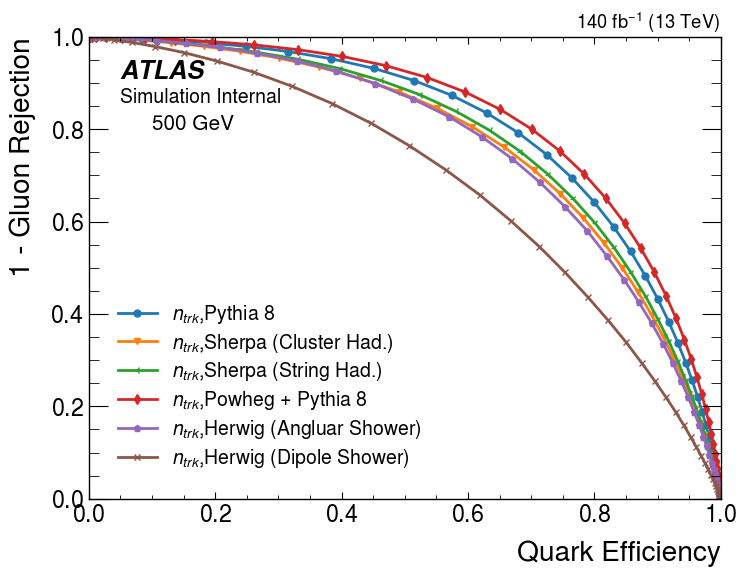

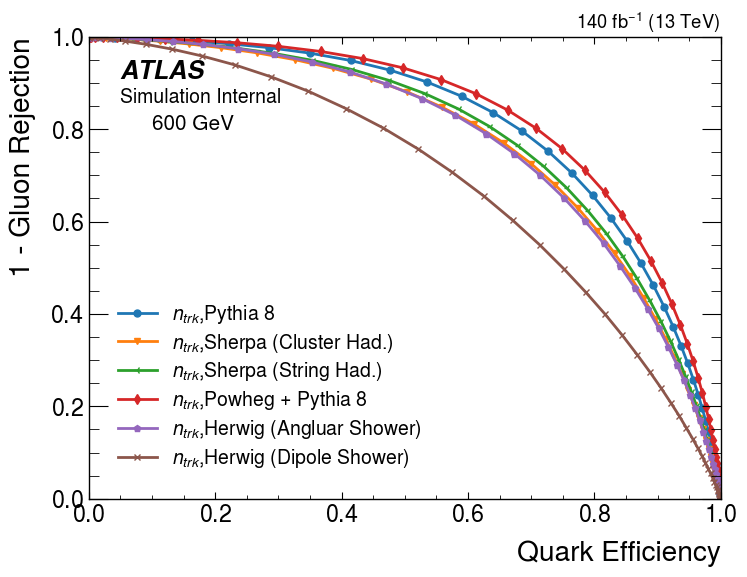

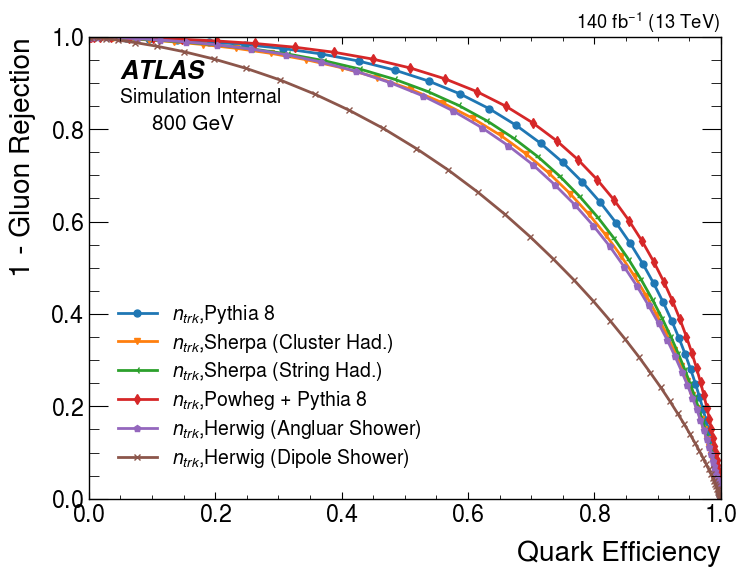

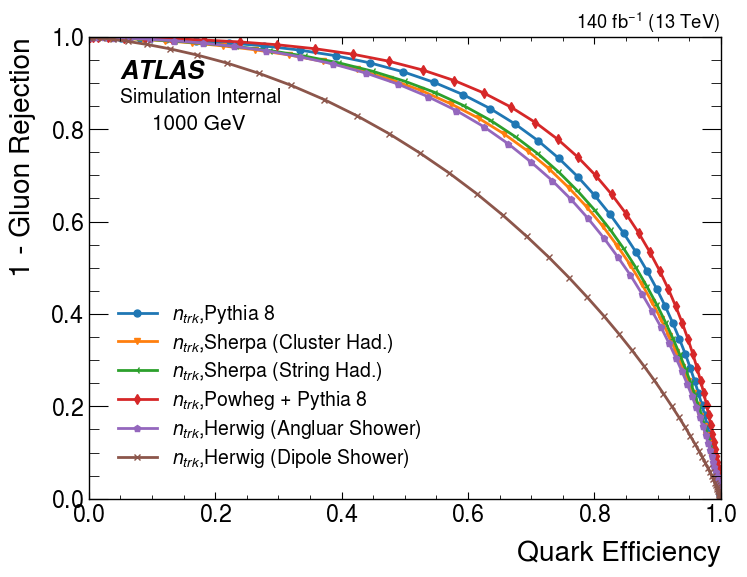

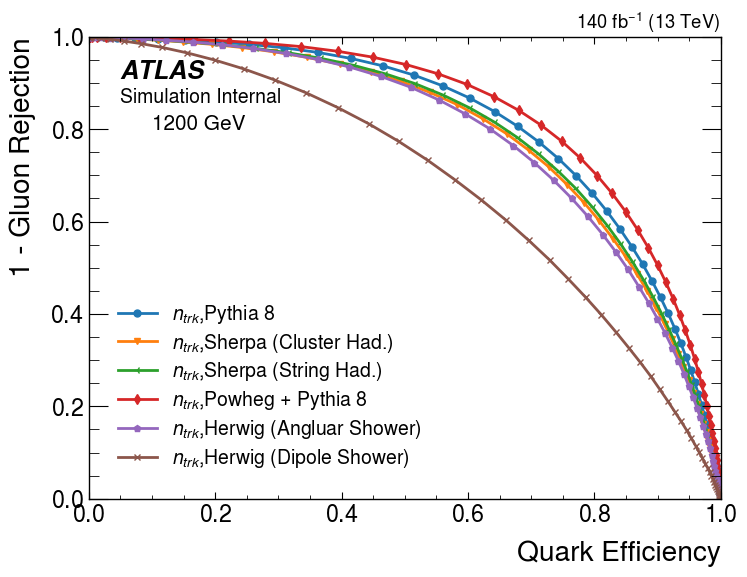

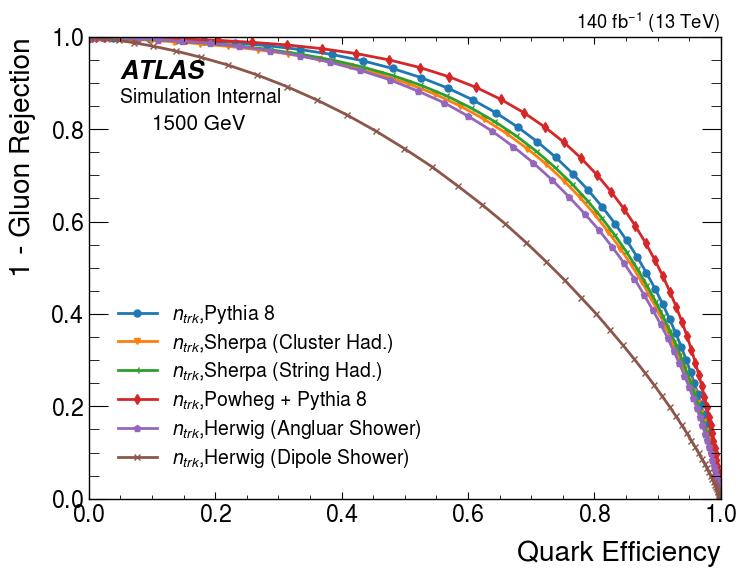

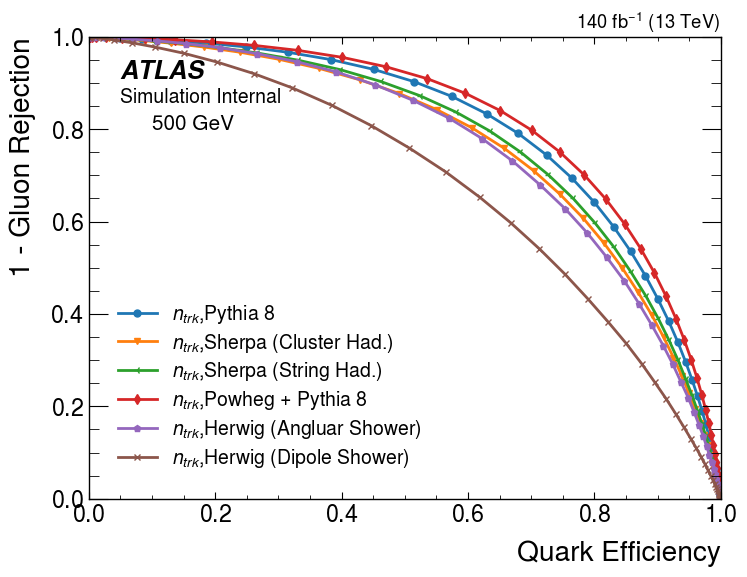

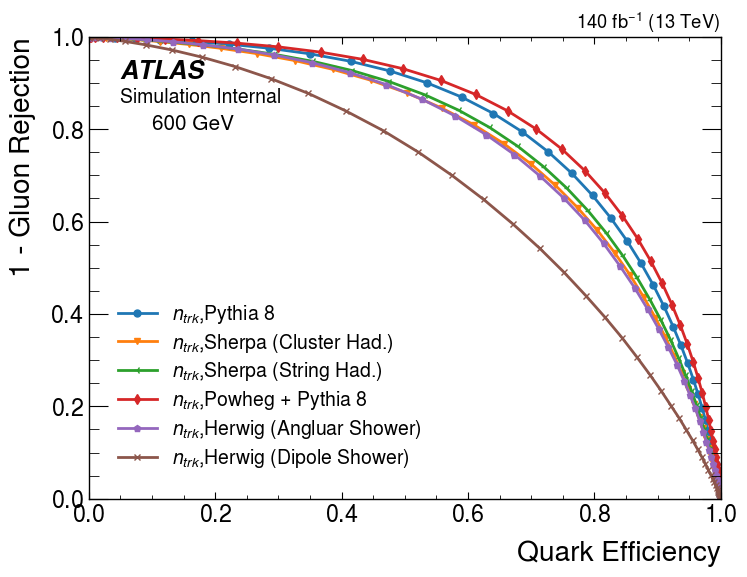

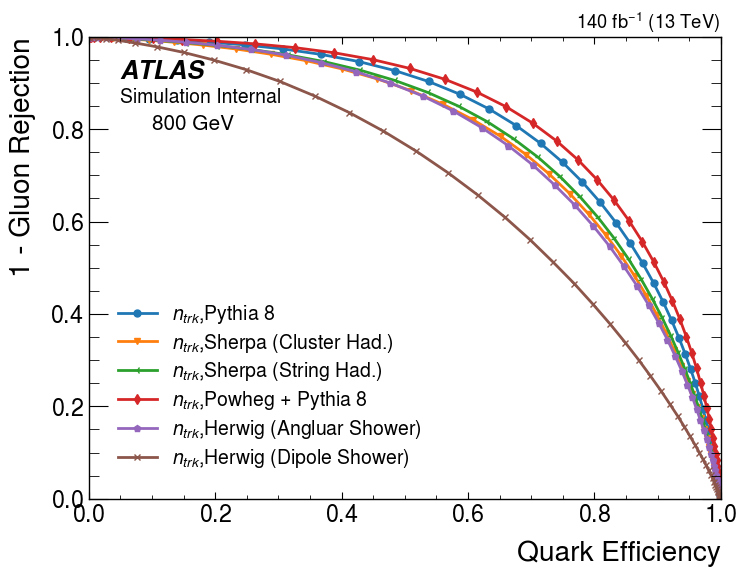

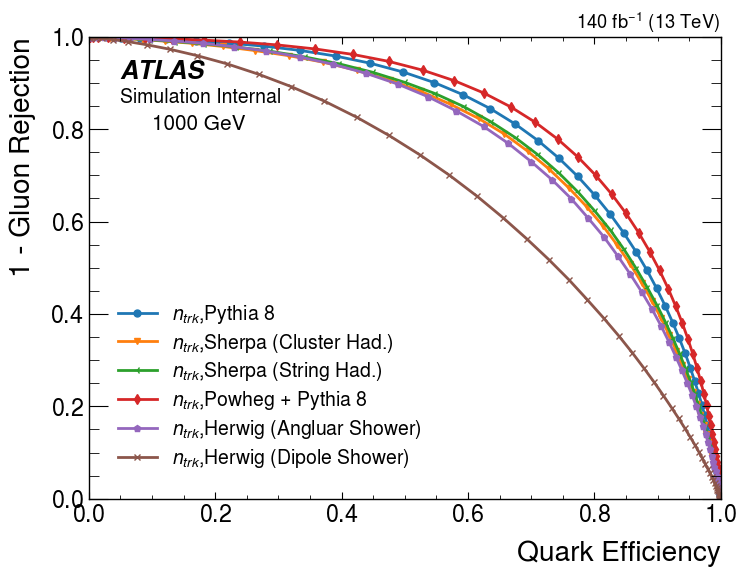

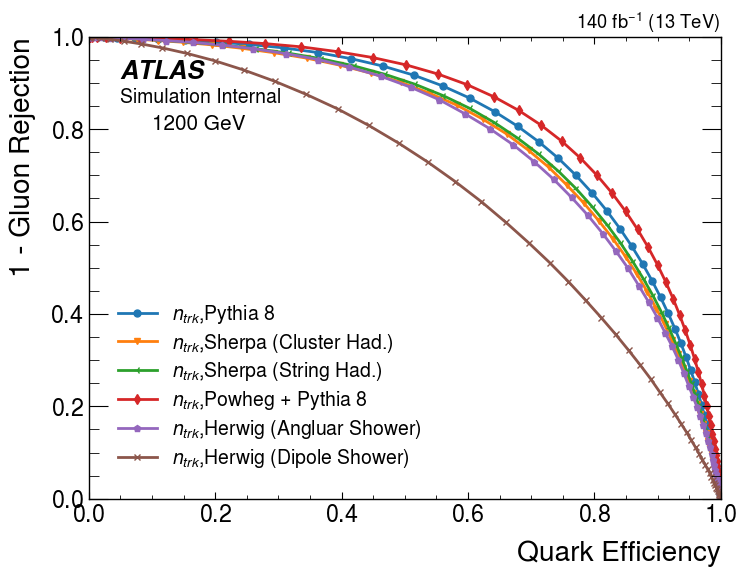

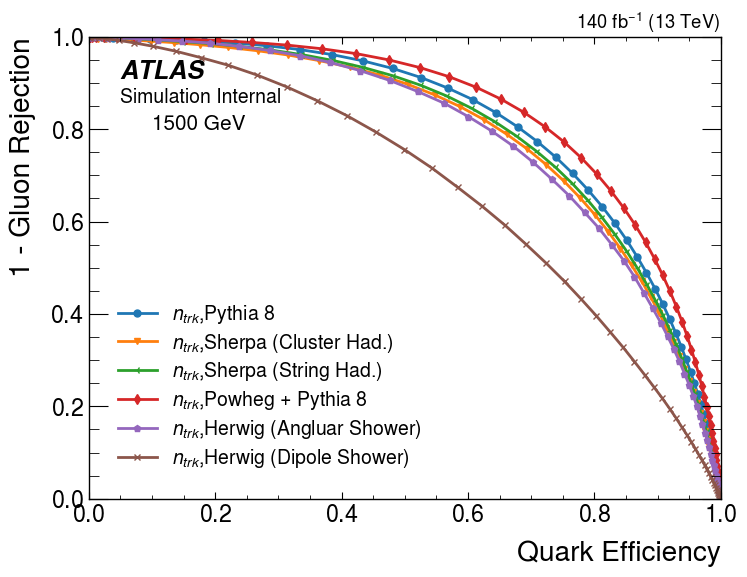

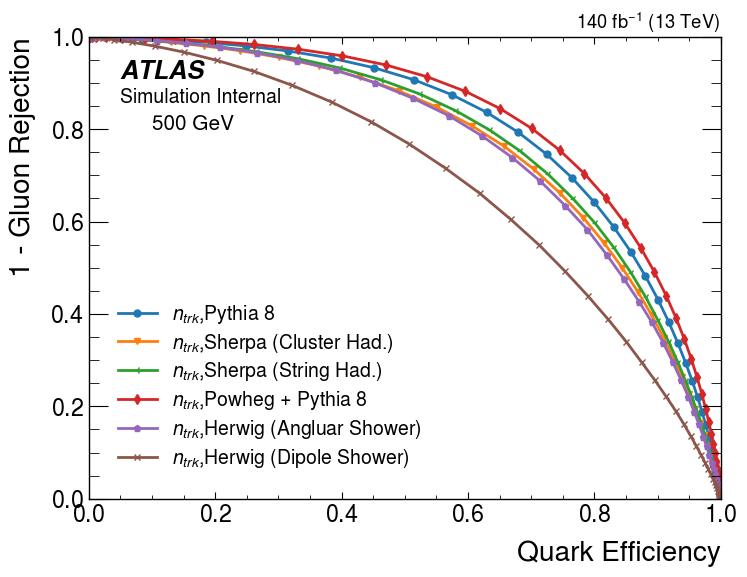

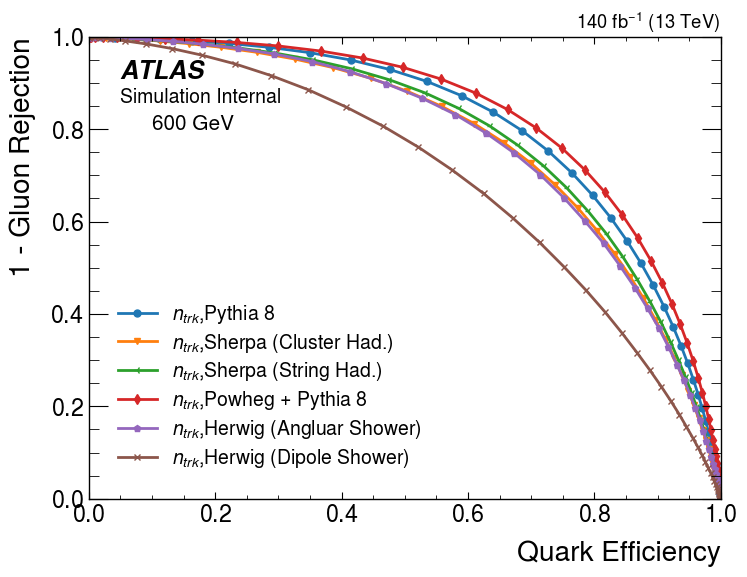

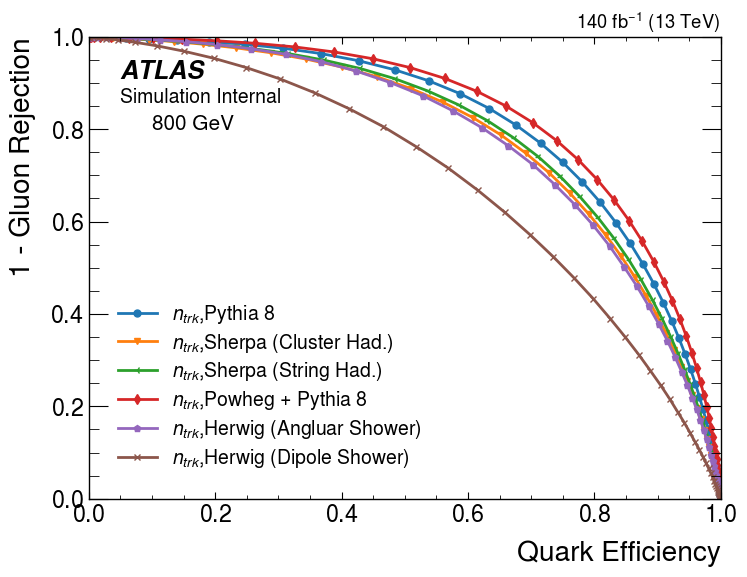

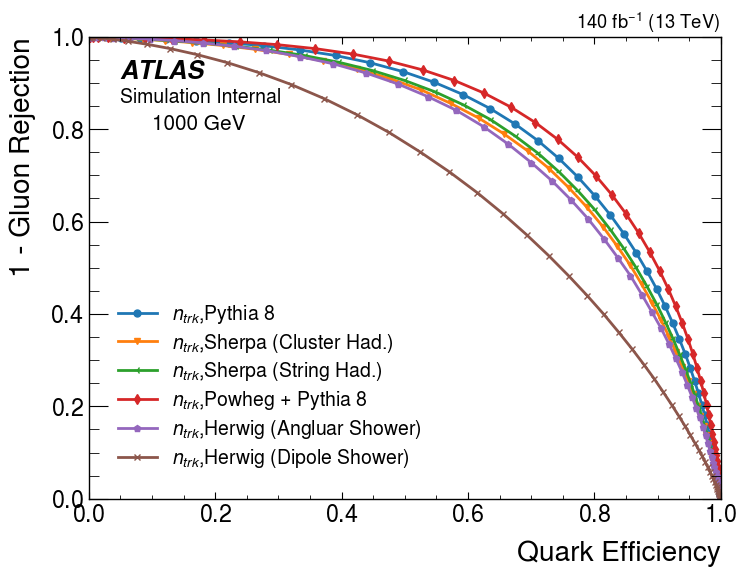

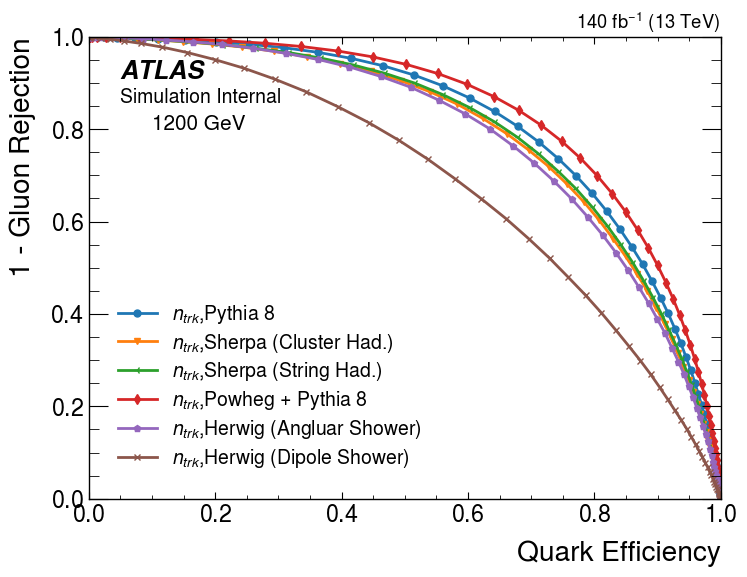

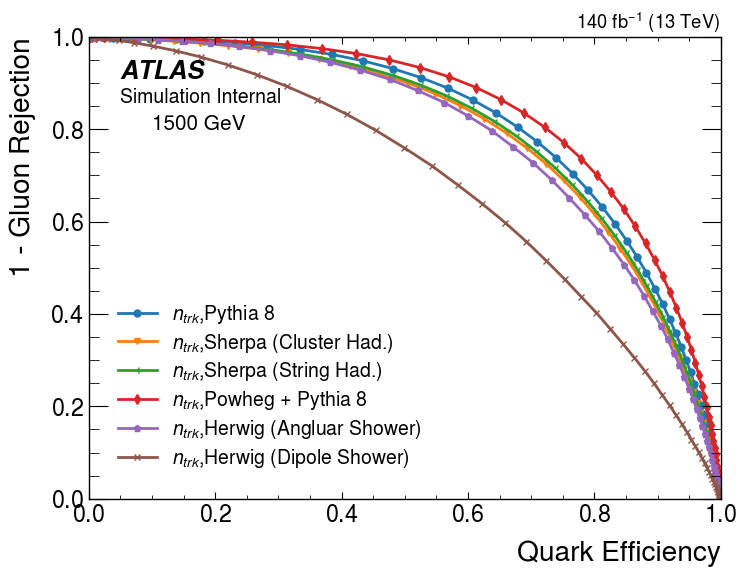

In [151]:
SFs = {}
Extraction_Results={}
#syst_list=['parton_shower/herwigangle']#,'parton_shower/herwigdipole']
syst_list=['nominal','hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for var in ['jet_nTracks']:
    for i, syst in enumerate(syst_list):
            syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
            Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
    Plot_ROC(Extraction_Results, output_path=Path('./ROC'),vars=[f'{var}'])

AUC as a function of jet pt

In [180]:
def Plot_AUC(Extraction_Results, output_path):
    swaped_Extraction_Results = {}
    label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
    vars = ['jet_nTracks', 'GBDT_newScore']
    

    for syst in Extraction_Results.keys():
        swaped_Extraction_Results[syst]={}
        label_keys = [*Extraction_Results[syst]['jet_nTracks'][500]]
        for l_ptrange in label_ptrange[:-1]:
            swaped_Extraction_Results[syst][l_ptrange] = {}
            for l_key in label_keys:
                swaped_Extraction_Results[syst][l_ptrange][l_key] = {}
                for l_var in vars:
                    swaped_Extraction_Results[syst][l_ptrange][l_key][l_var] = Extraction_Results[syst][l_var][l_ptrange][l_key]
        output_path_new = output_path
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True, exist_ok =True)

    eta_regions = {
        "ForwardandCentral": ['p_Quark', 'p_Gluon'],
        "Forward": ['p_Forward_Quark', 'p_Forward_Gluon'],
        "Central": ['p_Central_Quark', 'p_Central_Gluon']
    }
    lines=['o','v','3','d','p','x','*','s']
    for k, v in eta_regions.items():
        fig, ax0 = plt.subplots()
        aucc={}
        for var in vars:
            aulist=[]
            for l_ptrange in label_ptrange[:-1]:
            #for syst in Extraction_Results.keys():
                two_vars = swaped_Extraction_Results[syst][l_ptrange]
                p_Quark_unumpy = two_vars[v[0]]
                p_Gluon_unumpy = two_vars[v[1]]
               
                #var = vars[0]
                p_Quark = unumpy.nominal_values(p_Quark_unumpy[var])
                p_Gluon = unumpy.nominal_values(p_Gluon_unumpy[var])

                var_bins = HistBins[var]
                n_cut = len(var_bins)-1
                quark_effs = np.zeros(n_cut)
                gluon_rejs = np.zeros(n_cut)
                TPR = np.zeros(n_cut)
                FPR = np.zeros(n_cut)

                for cut_idx in range(n_cut):
                    TP = np.sum(p_Quark[:cut_idx])
                    TN = np.sum(p_Gluon[cut_idx:])
                    FP = np.sum(p_Gluon[:cut_idx])
                    FN = np.sum(p_Quark[cut_idx:])
                    TPR[cut_idx] = TP/(TP+FN) 
                    FPR[cut_idx] = FP/(FP+TN)
                    quark_effs[cut_idx] = TP ## After normalization 
                    gluon_rejs[cut_idx] = TN

                aulist.append(auc(FPR,TPR))
                
            aucc[var]=aulist
            i=vars.index(var)
                #ax0.plot(aucc[syst], label_ptrange, label =f"{Map_var_title[var]},{Map_gen[syst]}, AUC = %0.3f"%(aucc[syst]),marker=lines[i],markersize=5)
            hep.histplot(aucc[var],bins=label_ptrange,ax=ax0,histtype='errorbar',label = f"{Map_var_title[var]}",xerr=True,yerr=0.000001,marker=lines[i],markersize=6)
        
        ax0.legend(loc='lower left')
        hep.sort_legend(ax=ax0)
        ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
        hep.atlas.label(label='Internal',ax=ax0,lumi=140)
        ax0.set_xlabel("$p_{\mathrm{T}}$ [GeV]")
        ax0.set_ylabel("AUC")

        ax0.set_ylim(0.5,1)
        ax0.text(580,0.89,'Pythia 8',fontsize=15)
    #ax0.text(0.2,0.2,f'{syst}')
        fig_name = output_path_new / f"pt_{k}_{var}.pdf"
        fig.savefig(fig_name)
#plt.close()
        plt.show()
         


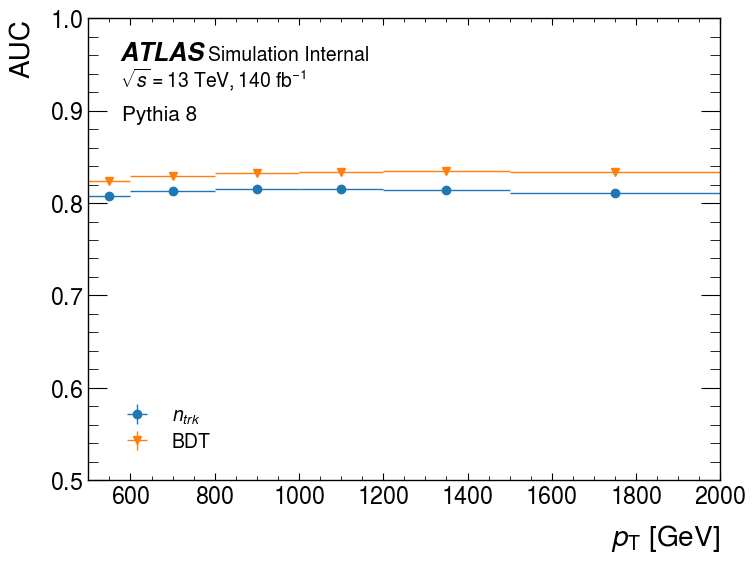

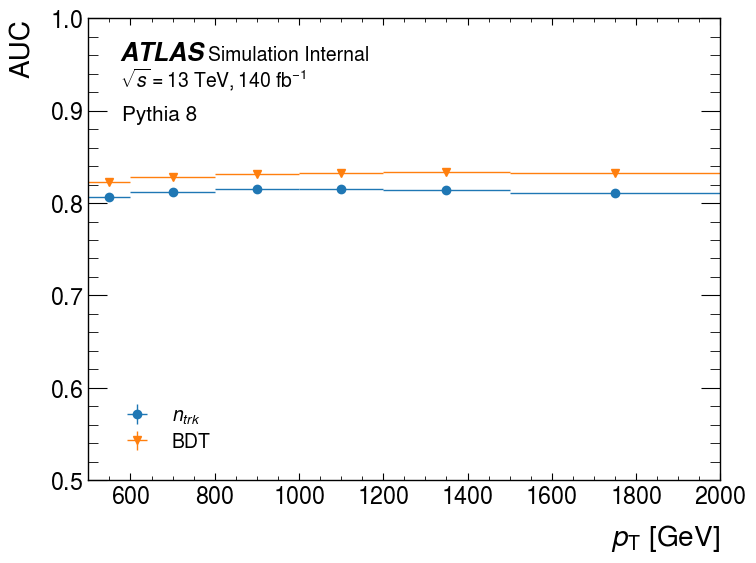

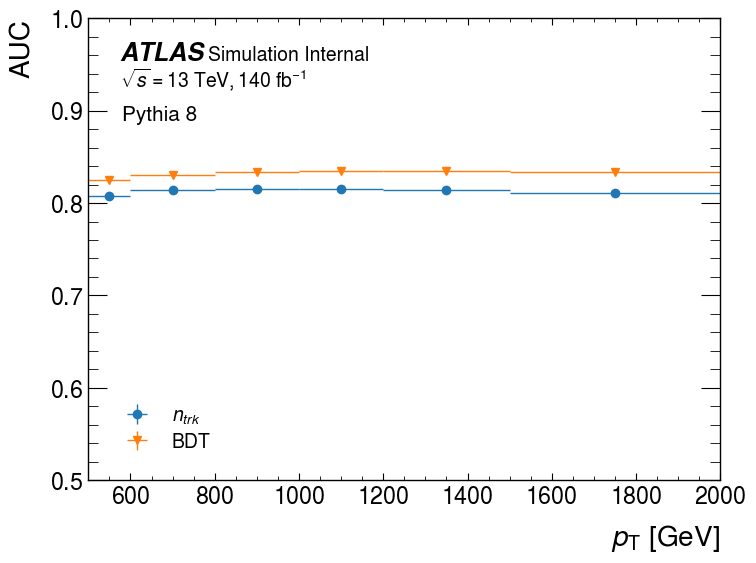

In [181]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for var in ['jet_nTracks']:
    for i, syst in enumerate(syst_list):
            syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
            Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
    Plot_AUC(Extraction_Results, output_path=Path('./ROC'))